## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from IPython import display

In [2]:
import sys
sys.path.append('../')
from src.models.convolutional_variational_autoencoder import IWAE, IWAE_MLMC

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Training and visualization

In [7]:
objectives = [
    'iwelbo',
    'pearson_ubo',
    'hellinger_lbo',
    'neyman_lbo',
    'pearson_lbo',
    'hellinger_ubo',
    'neyman_ubo'
]

In [8]:
def train_epoch(model, train_dataset, obj):
    for train_x in train_dataset:
        model.train_step(train_x, obj=obj)

def generate_images(model, epoch, test_sample):
    mean, logvar = model._encode(test_sample)
    z = model._reparameterize(mean, logvar)
    predictions = model._sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

        
def train_and_plot(model, train_dataset, test_dataset, epochs = 10, obj='elbo'):
    num_examples_to_generate = 16

    # keeping the random vector constant for generation (prediction) so
    # it will be easier to see the improvement.
    random_vector_for_generation = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])

    # Pick a sample of the test set for generating output images
    assert batch_size >= num_examples_to_generate
    for test_batch in test_dataset.take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]

    generate_images(model, 0, test_sample)
    plt.show()

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        train_epoch(model, train_dataset, obj)
        end_time = time.time()

        elbo = np.mean([model.compute_elbo(test_x) for test_x in test_dataset])
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                .format(epoch, elbo, end_time - start_time))
        generate_images(model, epoch, test_sample)
        # tight_layout minimizes the overlap between 2 sub-plots
        #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

In [9]:
def _plot_convergence(model, test_dataset, obj, grad=False):
    
    def get_grad(x, K):
        with tf.GradientTape() as tape:
            _obj =  model._compute_dobjective(x, K, obj)
            gradients = tape.gradient(_obj, model._decoder.trainable_variables)
        gradients = tf.concat([tf.reshape(g,[-1]) for g in gradients], axis=0)
        return gradients
    
    def get_L2_norm(L):
        L2 = 0
        for x in tmp_dataset:
            if grad==False:  L2 += model._compute_dobjective(x, 2**L, obj)**2
            elif grad==True: L2 += get_grad(x, 2**L)**2
        return np.sum(L2/100)
    
    tmp_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100])
                    .shuffle(100).batch(1))
    
    # evaluation of L2 norms
    levels = np.arange(10)
    res = [get_L2_norm(l) for l in levels]
    
    # plot
    plt.plot([2**l for l in levels], res)
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-l) for l in levels], c='gray')
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-2*l) for l in levels], c='gray')
    plt.yscale('log')
    plt.xscale('log')
    if grad==False: plt.legend([r'$\sqrt{E[||\Delta f||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    elif grad==True: plt.legend([r'$\sqrt{E[||\Delta \nabla f||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    
    return res
        
def plot_convergence(model, test_dataset, obj):
    res = {}
    plt.subplot(1,2,1)
    res['obj'] = _plot_convergence(model, test_dataset, obj, grad=False)
    plt.subplot(1,2,2)
    res['grad'] = _plot_convergence(model, test_dataset, obj, grad=True)
    return res

In [15]:
def _plot_convergence_sumo(model, test_dataset, obj, grad=False):
    
    def compute_dobjective_sumo(model, x, K):
        prob_ratios = model._compute_prob_ratios(x, K)
        _obj = tf.reduce_sum(model._compute_objectives(prob_ratios, obj))
        _obj -= tf.reduce_sum(model._compute_objectives(prob_ratios[:,:K-1], obj))
        return _obj
    
    def get_grad(x, K):
        with tf.GradientTape() as tape:
            _obj = compute_dobjective_sumo(model, x, K)
            gradients = tape.gradient(_obj, model._decoder.trainable_variables)
        gradients = tf.concat([tf.reshape(g,[-1]) for g in gradients], axis=0)
        return gradients
    
    def get_L2_norm(L):
        L2 = 0
        for x in tmp_dataset:
            if grad==False:  L2 += compute_dobjective_sumo(model, x, 2**L)**2
            elif grad==True: L2 += get_grad(x, 2**L)**2
        return np.sum(L2/100)
    
    tmp_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100])
                    .shuffle(100).batch(1))
    
    # evaluation of L2 norms
    levels = np.arange(10)
    res = [get_L2_norm(l) for l in levels]
    
    # plot
    plt.plot([2**l for l in levels], res)
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-l) for l in levels], c='gray')
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-2*l) for l in levels], c='gray')
    plt.yscale('log')
    plt.xscale('log')
    if grad==False: plt.legend([r'$\sqrt{E[||\Delta f||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    elif grad==True: plt.legend([r'$\sqrt{E[||\Delta \nabla f||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    
    return res
        
def plot_convergence_sumo(model, test_dataset, obj):
    res = {}
    plt.subplot(1,2,1)
    res['obj'] = _plot_convergence_sumo(model, test_dataset, obj, grad=False)
    plt.subplot(1,2,2)
    res['grad'] = _plot_convergence_sumo(model, test_dataset, obj, grad=True)
    return res

In [16]:
latent_dim = 3
model = IWAE_MLMC(latent_dim)

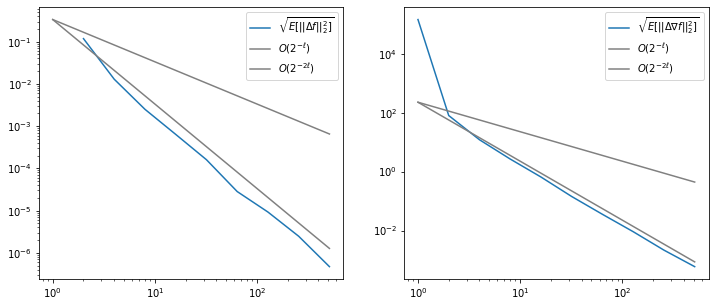

In [17]:
plt.figure(figsize=[12,5])
_ = plot_convergence_sumo(model, test_dataset, 'iwelbo')

In [19]:
for i in range(7):
    train_epoch(model, train_dataset, 'elbo')

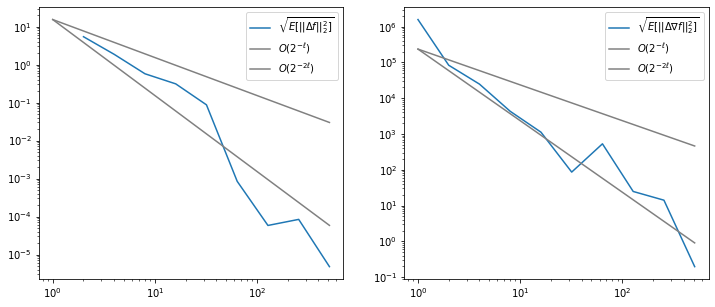

In [20]:
plt.figure(figsize=[12,5])
_ = plot_convergence_sumo(model, test_dataset, 'iwelbo')

In [ ]:
# set the dimensionality of the latent space to a plane for visualization later
res = {}
n_epochs = 3
for epoch in range(n_epochs+1):
    for obj in objectives:
        print('#epoch: {}, plotting convergence of {}'.format(epoch, obj))
        plt.figure(figsize=[15,10])
        res_tmp = plot_convergence(model, test_dataset, obj)
        res['{}_{}'.format(obj, epoch)] = res_tmp['obj']
        res['{}_grad_{}'.format(obj, epoch)] = res_tmp['grad']
        plt.savefig('../out/convolutional_variational_autoencoder/convergence_{}_{}_epoch(s).png'.format(obj, epoch))
        plt.close('all')
    if epoch==n_epochs: break
    print('now training ... \r'.format(epoch, obj))
    train_epoch(model, train_dataset, 'elbo')
# save results to the csv
_hash = int(time.time())%10000000
pd.DataFrame(res).to_csv('../out/convolutional_variational_autoencoder/{}.csv'.format(_hash))

In [ ]:
for i in range(7):
    train_epoch(model, train_dataset, 'elbo')

In [ ]:
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:16, :, :, :]

generate_images(model, 0, test_sample)
plt.show()